In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = '../data/augmented/'

In [2]:
files = os.listdir(DATASET_PATH)

rawx=[]
rawy=[]
for file in files:
    img = cv2.imread(os.path.join(DATASET_PATH,file),cv2.IMREAD_GRAYSCALE)
    rawx.append(img)
    rawy.append(int(file.split('_')[1]))

In [3]:
im_h, im_w = rawx[0].shape
num_classes = len(np.unique(rawy))

In [4]:
x = np.asarray(rawx)
y = np.asarray(rawy)
x = x.reshape(len(files),im_h*im_w)
print(x.shape)
print(y.shape)

(600, 40000)
(600,)


In [5]:
rawx= None
rawy= None

In [6]:
x = x / 255.

In [7]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([100, 100, 100, 100, 100, 100], dtype=int64))

In [8]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,stratify=y)

In [9]:
x = None
y = None

In [10]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)-1) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

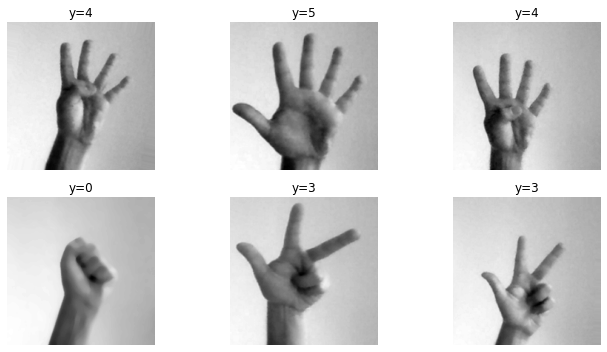

In [11]:
plot_6_images(xtrain,ytrain)

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
%time X_reduced = pca.fit_transform(xtrain)

Wall time: 4.86 s


In [13]:
print('dimension reduction from %d to %d after PCA preserving 99%% of variance' % (xtrain.shape[1],pca.n_components_))

dimension reduction from 40000 to 197 after PCA preserving 99% of variance


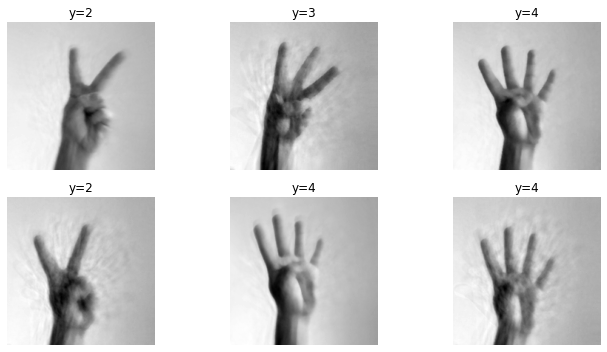

In [14]:
images = pca.inverse_transform(X_reduced)
plot_6_images(images,ytrain)

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score

classifs = [
           SGDClassifier(), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(random_state=37),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               ]

# Apply different classifiers

for name, clf in zip(classif_names, classifs):
    %time score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
    print("%s : %s Score :" % (name,score), " Worst: %.4f" % score.min())

Wall time: 10.9 s
SGD		 : [0.55625 0.69375 0.425  ] Score :  Worst: 0.4250
Wall time: 11.5 s
KNN		 : [0.75625 0.75    0.65625] Score :  Worst: 0.6562
Wall time: 9.28 s
DecisionTree	 : [0.66875 0.61875 0.58125] Score :  Worst: 0.5813
Wall time: 22.7 s
SVC		 : [0.75    0.75625 0.6875 ] Score :  Worst: 0.6875
Wall time: 4.47 s
RandomForest	 : [0.80625 0.84375 0.76875] Score :  Worst: 0.7688


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'bootstrap':[True,False],
        'n_estimators':[10,50,100,],
        'max_features':[5,10,'auto'],
        'max_depth':[5,10,None],
    }
]

clf = RandomForestClassifier(random_state=37)
grid_search_rf = GridSearchCV(clf,param_grid,cv=3,return_train_score=True,verbose=1)
%time grid_search_rf.fit(X_reduced,ytrain);

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:   17.7s finished


Wall time: 18.2 s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=37,
                                  

In [19]:
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

{'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}
0.8229166666666666


In [21]:
from sklearn.model_selection import cross_val_predict

Xtest_reduced = pca.transform(xtest)
ytest_pred = cross_val_predict(grid_search_rf.best_estimator_,Xtest_reduced,ytest,cv=3)
score = grid_search_rf.best_estimator_.score(Xtest_reduced, ytest)*100

print("Model score: %.2f%% on test dataset (%d obs)" % (score,len(ytest)))

Model score: 75.83% on test dataset (120 obs)


In [23]:
import pandas as pd

pd.crosstab(ytest, ytest_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,10,2,2,5,0,1,20
1,0,8,5,1,5,1,20
2,2,3,10,4,1,0,20
3,3,1,3,8,2,3,20
4,1,2,1,1,11,4,20
5,0,0,2,5,2,11,20
All,16,16,23,24,21,20,120


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

           0       0.62      0.50      0.56        20
           1       0.50      0.40      0.44        20
           2       0.43      0.50      0.47        20
           3       0.33      0.40      0.36        20
           4       0.52      0.55      0.54        20
           5       0.55      0.55      0.55        20

    accuracy                           0.48       120
   macro avg       0.49      0.48      0.49       120
weighted avg       0.49      0.48      0.49       120



In [29]:
import pickle

filename = 'model_classic.sav'
pickle.dump(grid_search_rf.best_estimator_, open(filename, 'wb'))

filename = 'model_classic_pca.sav'
pickle.dump(pca, open(filename, 'wb'))

In [30]:
import pickle
filename = 'model_classic.sav'
loaded_model = pickle.load(open(filename, 'rb'))

filename = 'model_classic_pca.sav'
loaded_pca = pickle.load(open(filename, 'rb'))

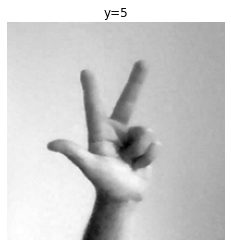

In [61]:
files = os.listdir('../data/originals/')
idx = random.randint(0,len(files)-1)
origimg = cv2.imread('../data/originals/'+files[idx],cv2.IMREAD_GRAYSCALE)

myimg = origimg/255.
myimg = cv2.resize(myimg,(im_h, im_w))
myimg = myimg.reshape(1,im_h* im_w)

xpca = loaded_pca.transform(myimg)

result = loaded_model.predict(xpca)
pred = result[0]

plt.imshow(origimg, cmap='gray');
plt.title('y=%d' % pred);
plt.axis('off');